<a href="https://colab.research.google.com/github/JCSR2022/Alura_Data_Science/blob/main/Testing_Relationships_with_Linear_Regression/precios_de_inmuebles_regresion_lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Precificación inmobiliaria**

**Objetivo**: Estimar los precios de los inmuebles.
 * Identificar los aspectos que tienen más influencia en la precificación de los inmuebles.
 * Entender cuál de todos estos aspectos es el más relevante.
 * Precificar un inmueble nuevo.

Base de datos simplificada e inspirada en [House Prices](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)



![](https://i.imgur.com/A8X79yq.jpeg)


# 0. Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.express as px


import plotly.graph_objects as go
from scipy.stats import gaussian_kde

# 1. Ajustando una recta

## Conociendo los datos

In [2]:
#Leyendo los datos

#direccion original
#https://github.com/JCSR2022/Alura_Data_Science/blob/main/Testing_Relationships_with_Linear_Regression/precios_casas.csv

git_raw = 'https://raw.githubusercontent.com/'
url_github = 'JCSR2022/Alura_Data_Science/main/Testing_Relationships_with_Linear_Regression/precios_casas.csv'
datos = pd.read_csv(git_raw + url_github)

datos.head()

,Id,area_primer_piso,tiene_segundo_piso,area_segundo_piso,cantidad_banos,capacidad_carros_garage,calidad_de_cocina_excelente,precio_de_venta
0,1,79.5224,1,79.3366,2,548,0,1027905.0
1,2,117.2398,0,0.0000,2,460,0,894795.0
2,3,85.4680,1,80.4514,2,608,0,1101855.0
3,4,89.2769,1,70.2324,1,642,0,690200.0
4,5,106.3705,1,97.8237,2,836,0,1232500.0


In [3]:
#Cuáles factores fueron colectados
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           1438 non-null   int64  
 1   area_primer_piso             1438 non-null   float64
 2   tiene_segundo_piso           1438 non-null   int64  
 3   area_segundo_piso            1438 non-null   float64
 4   cantidad_banos               1438 non-null   int64  
 5   capacidad_carros_garage      1438 non-null   int64  
 6   calidad_de_cocina_excelente  1438 non-null   int64  
 7   precio_de_venta              1438 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 90.0 KB


In [4]:
datos = datos.drop(columns='Id')
datos.columns

Index(['area_primer_piso', 'tiene_segundo_piso', 'area_segundo_piso',
       'cantidad_banos', 'capacidad_carros_garage',
       'calidad_de_cocina_excelente', 'precio_de_venta'],
      dtype='object')

## Correlación

**¿Cuáles factores están relacionados con el precio de la casa? ¿Cómo es esa relación?**

El coeficiente de correlación de Pearson nos permite medir la relación lineal entre variables, ofreciendo una escala que varía de -1 a 1, la cual interpretamos según su intensidad y dirección:

* **-1**: correlación negativa perfecta: a medida que una variable aumenta, la otra disminuye.  
* **0**: no hay relación lineal entre las variables.  
* **1**: correlación positiva perfecta: a medida que una variable aumenta, la otra también aumenta.  



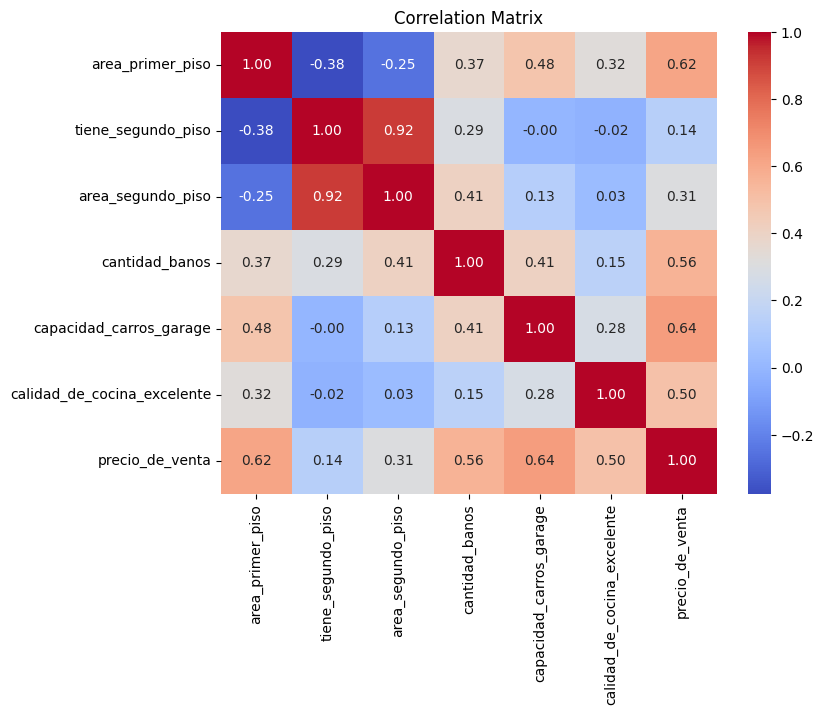

In [5]:
# Correlación
corr = datos.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

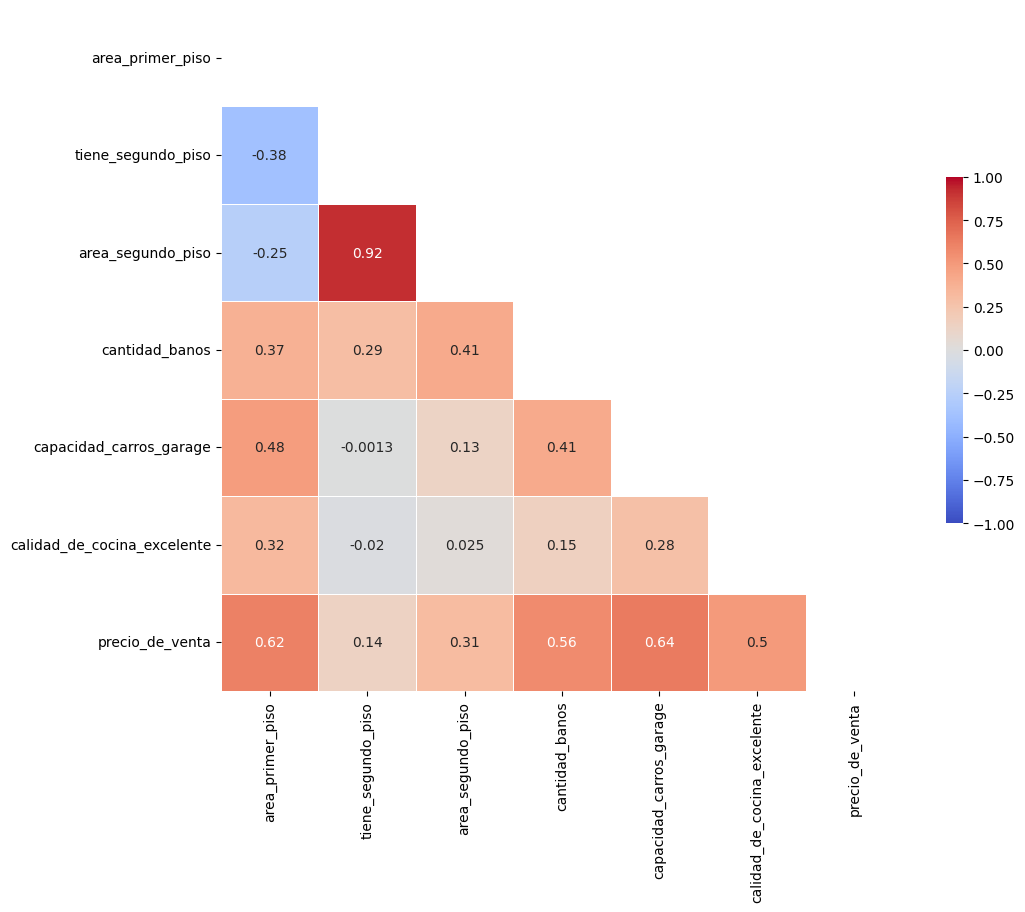

In [6]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mascara, cmap='coolwarm' , vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

# Mostrar el mapa de calor (heatmap)
plt.show()

In [7]:
corr_precio = corr['precio_de_venta'].sort_values(ascending=False).drop('precio_de_venta')
vis_corr_precio = (
    corr_precio
    .to_frame(name='Correlation with Sale Price')
    .style
    .background_gradient(cmap='coolwarm')
    .format("{:.3f}")
)

display(vis_corr_precio)


,Correlation with Sale Price
capacidad_carros_garage,0.640
area_primer_piso,0.617
cantidad_banos,0.563
calidad_de_cocina_excelente,0.496
area_segundo_piso,0.305
tiene_segundo_piso,0.139


In [8]:
# Actividad
# Cuáles factores están más correlacionados?

def top_correlations(corr_matrix, n=5):
    """
    Returns the top n most correlated variable pairs
    (by absolute correlation value).
    """

    # Copiamos la matriz
    corr = corr_matrix.copy()

    # Nos quedamos con el triángulo superior (sin diagonal)
    upper_triangle = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )

    # Convertimos a formato largo
    corr_pairs = (
        upper_triangle
        .stack()
        .reset_index()
    )

    corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

    # Ordenamos por valor absoluto
    corr_pairs = corr_pairs.reindex(
        corr_pairs['Correlation'].abs().sort_values(ascending=False).index
    )
    corr_pairs.reset_index(drop=True, inplace=True)
    return corr_pairs.head(n)


top_correlations(corr)

,Variable 1,Variable 2,Correlation
0,tiene_segundo_piso,area_segundo_piso,0.917101
1,capacidad_carros_garage,precio_de_venta,0.640214
2,area_primer_piso,precio_de_venta,0.616557
3,cantidad_banos,precio_de_venta,0.563132
4,calidad_de_cocina_excelente,precio_de_venta,0.496223


## Relacionando variables

In [9]:
# creando funciones standar para la visualización

def plot_scatter(df, x, y,unit_x=None,unit_y=None,corr=None,add_reg_line=True, color='steelblue'):
    """
    Plots a scatter plot between two variables
    with optional regression line.
    """

    plt.figure(figsize=(8,5))

    ax = sns.scatterplot(
        data=df,
        x=x,
        y=y,
        color=color,
        alpha=0.7
    )

    # Add regression line
    if add_reg_line:
        sns.regplot(
            data=df,
            x=x,
            y=y,
            scatter=False,
            color='darkred',
            ax=ax
        )

    ax.set_title(f'Relationship between {x} and {y} \n{f"correlation:{corr:.6f}" if corr else ''}', fontsize=13)
    ax.set_xlabel(x+(' ['+unit_x+']' if unit_x else ''), fontsize=11)
    ax.set_ylabel(y+(' ['+unit_y+']' if unit_y else ''), fontsize=11)

    sns.despine()  # clean look
    plt.tight_layout()

    return plt



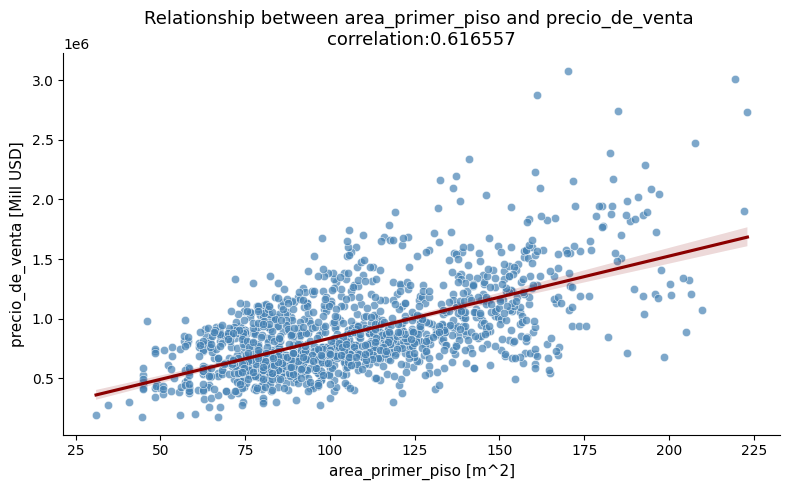

In [10]:
# Cómo se relacionan el área construída y el precio del inmueble?
corr_area_precio = corr.loc['area_primer_piso','precio_de_venta']
#print(f'Correlación entre area_primer_piso y precio_de_venta: {corr_area_precio:.5f}')
#print()
plot_scatter(datos, 'area_primer_piso', 'precio_de_venta','m^2','Mill USD',corr_area_precio).show()

In [11]:
# Aparentemente mientras mayor es el área del primer piso, mayor es el precio de la casa.
# E si quisieramos trazar una línea que nos permita describir este comportamiento?

#px.scatter(datos, x='area_primer_piso', y='precio_de_venta', trendline='ols', trendline_color_override='red')


def plot_scatter(df, x, y, unit_x=None, unit_y=None,
                 corr=None, add_reg_line=True, color='steelblue'):
    """
    Interactive scatter plot using Plotly Express
    with optional OLS regression line.
    """

    # Compute correlation if not provided
    if corr is None:
        corr = df[[x, y]].corr().iloc[0, 1]

    # Axis labels with units
    x_label = x + (f" [{unit_x}]" if unit_x else "")
    y_label = y + (f" [{unit_y}]" if unit_y else "")

    # Title
    title_text = (
        f"Relationship between {x} and {y}"
        f"<br><sup>Correlation: {corr:.6f}</sup>"
    )

    fig = px.scatter(
        df,
        x=x,
        y=y,
        trendline="ols" if add_reg_line else None,
        color_discrete_sequence=[color],
        opacity=0.7
    )

    # Update layout for professional look
    fig.update_layout(
        title=title_text,
        xaxis_title=x_label,
        yaxis_title=y_label,
        template="simple_white",
        width=800,
        height=500
    )

    # Change regression line color (if exists)
    if add_reg_line:
        fig.data[1].line.color = "darkred"

    return fig

## Mejor recta

In [12]:
# Cuál es la recta que mejor se ajusta a esta relación
plot_scatter(datos, 'area_primer_piso', 'precio_de_venta','m^2','Mill USD').show()

# 2. Explicando la recta
Ajustamos una recta entre los $m^2$ del primer piso y el precio de la casa. Queremos explicar el precio de la casa a partir de su tamaño, por eso decimos que:

* Variable explicativa/independiente: Área del primer piso  
* Variable de respuesta/dependiente: Precio de la casa  

In [13]:
#Quién es nuestra variable de respuesta?

# sns.displot(datos, x='precio_de_venta', kde=True)
# plt.show()

def dist_plot(df, column, unit=None, bins=30, color='steelblue', show_kde=True):
    """
    Parameters:
    - df: DataFrame
    - column: column name to analyze
    - unit: optional unit string (e.g., 'BRL', 'm²')
    - bins: number of histogram bins
    - color: histogram color
    - show_kde: whether to overlay KDE curve
    """

    data = df[column].dropna()

    # Basic statistics
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()

    label = column + (f" [{unit}]" if unit else "")

    # Histogram
    fig = px.histogram(
        df,
        x=column,
        nbins=bins,
        opacity=0.75,
        color_discrete_sequence=[color]
    )

    # KDE curve
    if show_kde:
        kde = gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 500)
        y_kde = kde(x_range)

        # Scale KDE to histogram
        y_kde_scaled = y_kde * len(data) * (data.max() - data.min()) / bins

        fig.add_trace(
            go.Scatter(
                x=x_range,
                y=y_kde_scaled,
                mode='lines',
                name='KDE',
                line=dict(color='darkred', width=2)
            )
        )

    # # Add mean and median lines
    # fig.add_vline(x=mean_val, line_dash="dash",
    #               line_color="green",
    #               annotation_text="Mean",
    #               annotation_position="top left")

    # fig.add_vline(x=median_val, line_dash="dot",
    #               line_color="purple",
    #               annotation_text="Median",
    #               annotation_position="top right")

    # Layout
    fig.update_layout(
        title=f"Distribution of {column}"
              f"<br><sup>Mean: {mean_val:.2f} | "
              f"Median: {median_val:.2f} | "
              f"Std: {std_val:.2f}</sup>",
        xaxis_title=label,
        yaxis_title="Frequency",
        template="simple_white",
        width=850,
        height=500
    )

    return fig

dist_plot(datos,'precio_de_venta','Mill USD').show()

### Separando datos para entrenamiento y para prueba

El conjunto de **entrenamiento** se utiliza para ajustar el modelo, mientras que el conjunto de **prueba** se usa para evaluar su desempeño al predecir precios de viviendas no vistos durante el entrenamiento, lo que ayuda a la generalización del modelo.

In [14]:
# import train_test_split
from sklearn.model_selection import train_test_split

#set random
my_random_state = 230

In [15]:
#Datos de entrenamiento para usar la fórmula

y = datos['precio_de_venta']
x = datos.drop(columns='precio_de_venta')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=my_random_state)

df_train = pd.DataFrame(x_train)
df_train['precio_de_venta'] = y_train

df_test = pd.DataFrame(x_test)
df_test['precio_de_venta'] = y_test


train_test_split permite Estratificación,
train_test_split(x, y, test_size=0.3, stratify=y) garantiza que: Si 20% de los datos son clase 1,entonces 20% del train y 20% del test también lo serán.

ejemplo:
Dataset original: 90% A | 10% B
Sin estratificación puedes tener:
Train: 97% A | 3% B
Test: 85% A | 15% B

Con estratificación:
Train: 90% A | 10% B
Test: 90% A | 10% B



En proyectos reales ni siquiera se usa solo train_test_split, se usa:
-KFold
-StratifiedKFold
-cross_val_score

In [16]:
# import ols
from statsmodels.formula.api import ols

modelo_0 = ols(formula='precio_de_venta ~ area_primer_piso', data=df_train).fit()



In [17]:
# ajustando el primer modelo


## Analizando los coeficientes

(intensidad, dirección y significancia)




In [18]:
# visualizando los parámetros
modelo_0.params

,0
Intercept,152909.288334
area_primer_piso,6793.641641


In [19]:
# El resumen del modelo
modelo_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        precio_de_venta   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     608.3
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          2.22e-105
Time:                        01:57:36   Log-Likelihood:                -14082.
No. Observations:                1006   AIC:                         2.817e+04
Df Residuals:                    1004   BIC:                         2.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.529e+05   3.07e+04      4.981      0.000    9.27e+04    2.13e+05
area_primer_piso  6793.6416    275.455     24.663      0.000    6253.109    7334.175
==============================================================================
Omnibus:                      190.778   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.457
Skew:                           0.998   Prob(JB):                    1.72e-105
Kurtosis:                       5.743   Cond. No.                         373.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- El **punto de intercepción** es el valor esperado del precio de la casa cuando todas las demás variables son cero. En este caso, cuando todas las demás variables, incluida el área del primer piso, son cero, el precio esperado de la casa es de $145.196,40. No siempre se tiene una interpretación práctica para este número.

- El **efecto individual** del área es de \$6.833,97. Esto indica que por cada metro cuadrado adicional al área del primer piso, se espera que el precio de la casa aumente en promedio \$6.833,97.

<img src="https://i.ibb.co/CJwfMgW/coeficientes.png" alt="coeficientes" border="0">


Y = β₀ + β₁*Xi
Variable Respuesta (Y): También llamada variable dependiente, es aquella que estamos tratando de predecir.

Intercepto (β₀): El punto donde la línea de regresión intercepta el eje vertical (Y), es decir, el valor de Y cuando X es igual a 0.

Variable Explicativa (X): También llamada variable independiente, es el factor que usamos para predecir y explicar la variable respuesta.

Coeficientes de Regresión (β₁): Impacto de cada variable explicativa X en la variable respuesta, es el efecto de X en Y.

Error Residual (e): Diferencia entre los valores reales y previstos de la variable respuesta.

## Explicabilidad del modelo

**¿En qué medida la variación del área explica los diversos precios de las casas?**  

En este caso, recurrimos a la métrica R², el coeficiente de determinación. El R² varía de 0 a 1, donde 1 indica un ajuste perfecto del modelo a los datos, es decir, todas las variaciones en la variable dependiente son explicadas por las variables independientes en el modelo. Por otro lado, un R² de 0 indica que el modelo no explica ninguna variabilidad en la variable dependiente.

In [20]:
# observando el R²
modelo_0.rsquared

np.float64(0.37728010994297867)

## Entendiendo el resíduo

In [21]:
# Quiénes son los residuos?
modelo_0.resid

,0
1303,-193023.838744
326,-144522.356193
386,399612.747641
615,-68449.596607
236,166010.592859
...,...
777,465872.680999
271,-497642.319788
723,461150.204718
560,-540482.733402


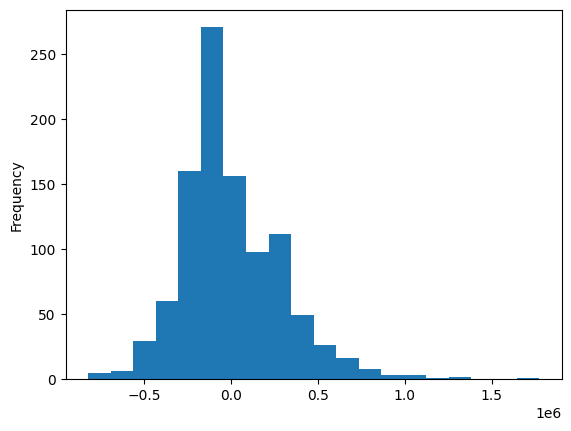

In [22]:
# Cómo están distribuidos
modelo_0.resid.plot.hist(bins=20)
plt.show()



<img src="https://i.ibb.co/zGTB35V/residuos.png" alt="residuos" border="0">

## Obteniendo el R² de la previsión

In [23]:
# definiendo la 'Y' prevista
y_predict = modelo_0.predict(x_test)

In [24]:
# importando el r2_score
from sklearn.metrics import r2_score

In [25]:
# mostrando el resultado de r²
print(f"Coeficiente de determinacion: {r2_score(y_test, y_predict):.2f}")

Coeficiente de determinacion: 0.39


# 3. Añadiendo otras características

El modelo con un solo factor nos mostró un R² de 0.38, es decir, aproximadamente el 38% de la variación observada en los precios de las casas puede explicarse por la variación en el área.  
Esto indica que aún existe una cantidad significativa de variación que no está siendo capturada por este modelo específico. Analizaremos otros factores para explicar el precio de las casas.

## Analizando los factores

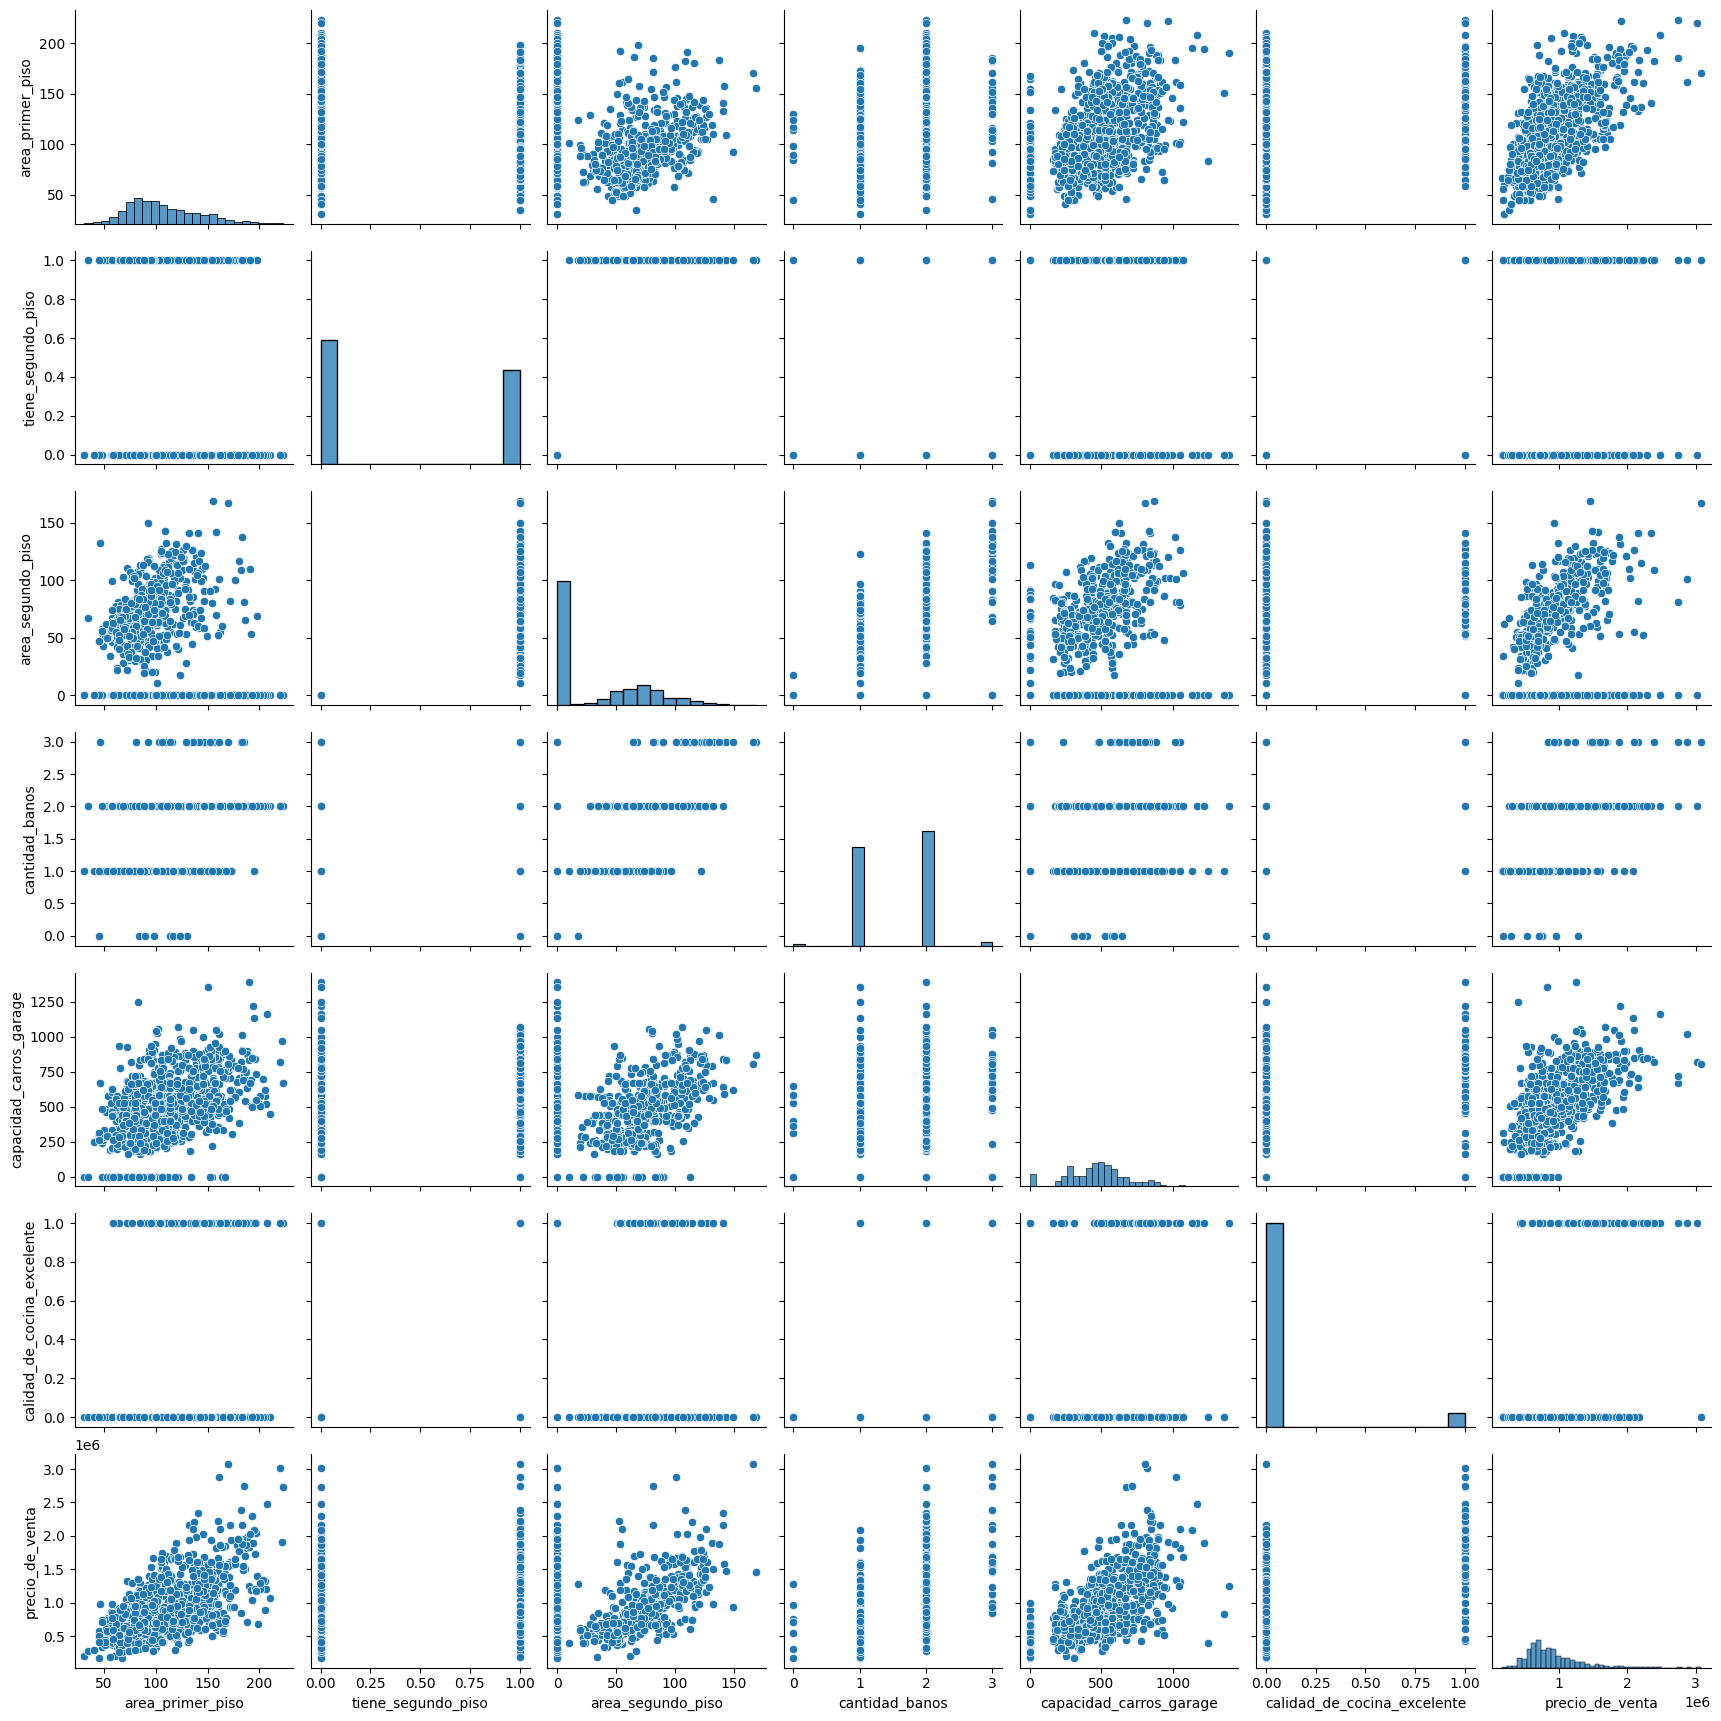

In [26]:
# cuáles otras características podrían explicar el precio de los inmuebles?
sns.pairplot(datos)

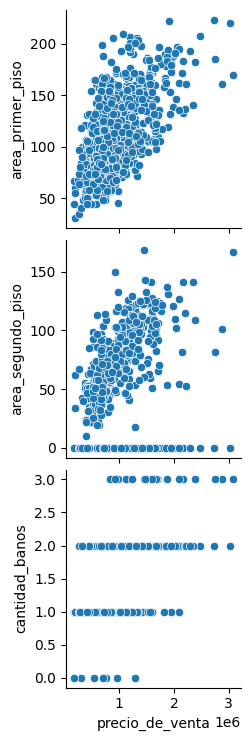

In [27]:
#Vamos a analizar solamente y_vars='precio_de_venta'
sns.pairplot(datos, y_vars=['area_primer_piso','area_segundo_piso','cantidad_banos'],x_vars='precio_de_venta')
#

## Añadiendo factores al modelo

In [28]:
# importando la api de statsmodels
import statsmodels.api as sm

In [29]:
# Añadiendo una constante
x_train = sm.add_constant(x_train)
x_train.head()

,const,area_primer_piso,tiene_segundo_piso,area_segundo_piso,cantidad_banos,capacidad_carros_garage,calidad_de_cocina_excelente
1303,1.0,65.7732,0,0.0000,1,0,0
326,1.0,55.3684,1,55.3684,1,189,0
386,1.0,74.6916,1,107.4853,2,560,0
615,1.0,103.6764,0,0.0000,1,440,0
236,1.0,94.2006,1,67.8170,2,457,0


In [30]:
# Creando el modelo de regresión (con todas las variables): saturado
modelo_1 = sm.OLS(y_train, x_train[['const',
        'area_primer_piso', 'tiene_segundo_piso','area_segundo_piso',
       'cantidad_banos', 'capacidad_carros_garage',
       'calidad_de_cocina_excelente']]).fit()

In [31]:
# Modelo sin el área del segundo piso
modelo_2 = sm.OLS(y_train, x_train[['const',
      'area_primer_piso', 'tiene_segundo_piso',
       'cantidad_banos', 'capacidad_carros_garage',
       'calidad_de_cocina_excelente']]).fit()

In [32]:
# Modelo sin la información del garage
# Modelo sin el área del segundo piso
modelo_3 = sm.OLS(y_train, x_train[['const',
      'area_primer_piso','tiene_segundo_piso',
       'cantidad_banos',
       'calidad_de_cocina_excelente']]).fit()

In [33]:
# Resumen del modelos
modelos = [modelo_0, modelo_1, modelo_2, modelo_3]

In [34]:
for i,modelo in enumerate(modelos):
    print("**********************************************************")
    print(f'************************Modelo {i}**************************')
    print("**********************************************************")
    print(modelo.summary())
    print()
    print()
    print()

**********************************************************
************************Modelo 0**************************
**********************************************************
                            OLS Regression Results                            
Dep. Variable:        precio_de_venta   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     608.3
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          2.22e-105
Time:                        01:57:45   Log-Likelihood:                -14082.
No. Observations:                1006   AIC:                         2.817e+04
Df Residuals:                    1004   BIC:                         2.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    st

In [35]:
for i,modelo in enumerate(modelos):
    print(f'Modelo {i}, R^2: {modelo.rsquared:.2f}')

Modelo 0, R^2: 0.38
Modelo 1, R^2: 0.74
Modelo 2, R^2: 0.71
Modelo 3, R^2: 0.65


## Comparando los modelos
Cuál es el modelo?


In [53]:
# Cuántos parámetros tiene el modelo?

for i,modelo in enumerate(modelos):
    print(f'Modelo {i}, parámetros: {len(modelo.params)}')
    print( modelo.params)
    print()


Modelo 0, parámetros: 2
Intercept           152909.288334
area_primer_piso      6793.641641
dtype: float64

Modelo 1, parámetros: 7
const                          -61251.345023
area_primer_piso                 4875.960595
tiene_segundo_piso            -134400.681632
area_segundo_piso                4709.382433
cantidad_banos                  64629.613915
capacidad_carros_garage           432.761421
calidad_de_cocina_excelente    377918.770713
dtype: float64

Modelo 2, parámetros: 6
const                         -141763.879013
area_primer_piso                 4746.113406
tiene_segundo_piso             192920.027424
cantidad_banos                 106978.502270
capacidad_carros_garage           507.406766
calidad_de_cocina_excelente    384861.525470
dtype: float64

Modelo 3, parámetros: 5
const                         -129979.678094
area_primer_piso                 6119.653184
tiene_segundo_piso             221306.959705
cantidad_banos                 149036.289458
calidad_de_cocina_excel

# métodos automáticos de selección de variables

1. El método de forward selection comienza con un modelo sin variables explicativas y agrega una a una, eligiendo en cada paso la variable que más mejora el modelo de acuerdo con un criterio estadístico específico, como el menor valor de p-valor o el mayor aumento en el R² ajustado.

2. El backward selection inicia con todas las variables posibles en el modelo y, de manera iterativa, elimina la variable que menos contribuye al modelo, nuevamente basándose en criterios como el p-valor o el impacto en el R² ajustado.

3. El stepwise selection es una combinación de los dos métodos anteriores, donde las variables pueden ser agregadas o eliminadas en cada paso, dependiendo de su contribución a la mejora del modelo.

Estos métodos de selección automática son herramientas poderosas que ayudan en la identificación del modelo más parsimonioso, es decir, aquel que puede explicar los datos de manera eficiente sin ser excesivamente complejo. Sin embargo, es crucial que el científico de datos comprenda y supervise el proceso, ya que la elección automática puede, a veces, introducir sesgo o sobreajuste, especialmente si el criterio de selección no es bien elegido o si el modelo no es validado adecuadamente con datos nuevos o de prueba.

# 4. Precificando las casas

## Obteniendo el R² de la previsión

In [37]:
# Añadiendo una constante en X_test


In [38]:
# Previsión con el modelo 3


In [39]:
# Cuál es el r² de la previsión?


In [40]:
# Cuál es el R² del entrenamiento?


## Precificando una casa

<img src="https://i.ibb.co/SvG4V4j/costo.png" alt="costo" border="0">

In [41]:
#Nuevo inmueble


In [42]:
# Cuál es el precio del inmueble de acuerdo con el modelo 0?


In [43]:
#Cuál es el precio del inmueble de acuerdo con el modelo 3?


## Precificando varias casas

<img src="https://i.imgur.com/i0skFlB.jpeg" width="600"/>

In [44]:
# Leyendo varias casas?


In [45]:
# Añadiendo una constante


In [46]:
# Cuál es el precio de estas nuevas casas?
# precio_casas = pd.DataFrame()


# 5. Investigando el modelo





## Multicolinearidad

Cuando dos o más cosas que estás intentando estudiar son tan parecidas que es difícil determinar cuánto está influyendo cada una de ellas en el resultado.

In [47]:
# importar el VIF de statsmodel


In [48]:
# VIF 1


In [49]:
# VIF 3


## Análisis de los residuos

Residuos: la discrepancia entre los valores reales y los valores que el modelo predice para los mismos puntos de datos.

<img src="https://i.ibb.co/9bmySbm/heterocedasticidad.png" alt="heterocedasticidad" border="0">

# Otras actividades

## Actividad 1

Como persona Científica de Datos, estás a cargo del análisis del problema de fijación de precios de habitaciones de hoteles, utilizando el conjunto de datos proporcionado. Para ello, dispones de este dataset:hoteis.csv.

En esta actividad, tu tarea consiste en llevar a cabo las siguientes etapas:

análisis inicial con el PairPlot de Seaborn;
construir modelos de regresión lineal; y
realizar la comparación de estos modelos.